<a href="https://colab.research.google.com/github/nurielw05/doc_transformers/blob/main/LayoutLM/Fine_tuning_LayoutLMForTokenClassification_on_FUNSD_Extencion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [1]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 4248, done.
remote: Total 4248 (delta 0), reused 0 (delta 0), pack-reused 4248
Receiving objects: 100% (4248/4248), 7.29 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (2087/2087), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./unilm/layoutlm
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 635 kB 9.7 MB/s 
     |████████████████████████████████| 195 kB 20.4 MB/s 
     |████████████████████████████████| 5.5 MB 66.0 MB/s 
     |████

In [2]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 104369, done.
remote: Total 104369 (delta 0), reused 0 (delta 0), pack-reused 104369
Receiving objects: 100% (104369/104369), 96.96 MiB | 23.50 MiB/s, done.
Resolving deltas: 100% (77118/77118), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |██████████████████████████

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [3]:
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

--2022-08-06 17:22:31--  https://guillaumejaume.github.io/FUNSD/dataset.zip
Resolving guillaumejaume.github.io (guillaumejaume.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to guillaumejaume.github.io (guillaumejaume.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16838830 (16M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  16.06M  --.-KB/s    in 0.06s   

2022-08-06 17:22:31 (286 MB/s) - ‘dataset.zip’ saved [16838830/16838830]

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/training_data/
  inflating: dataset/training_data/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset/
   creating: __MACOSX/dataset/training_data/
  inflating: __MACOSX/dataset/training_data/._.DS_Store  
   creating: dataset/training_data/images/
  inflating: dataset/training_data/images/92091873.png  
   creating: __MACOSX/dataset/training_data/images

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

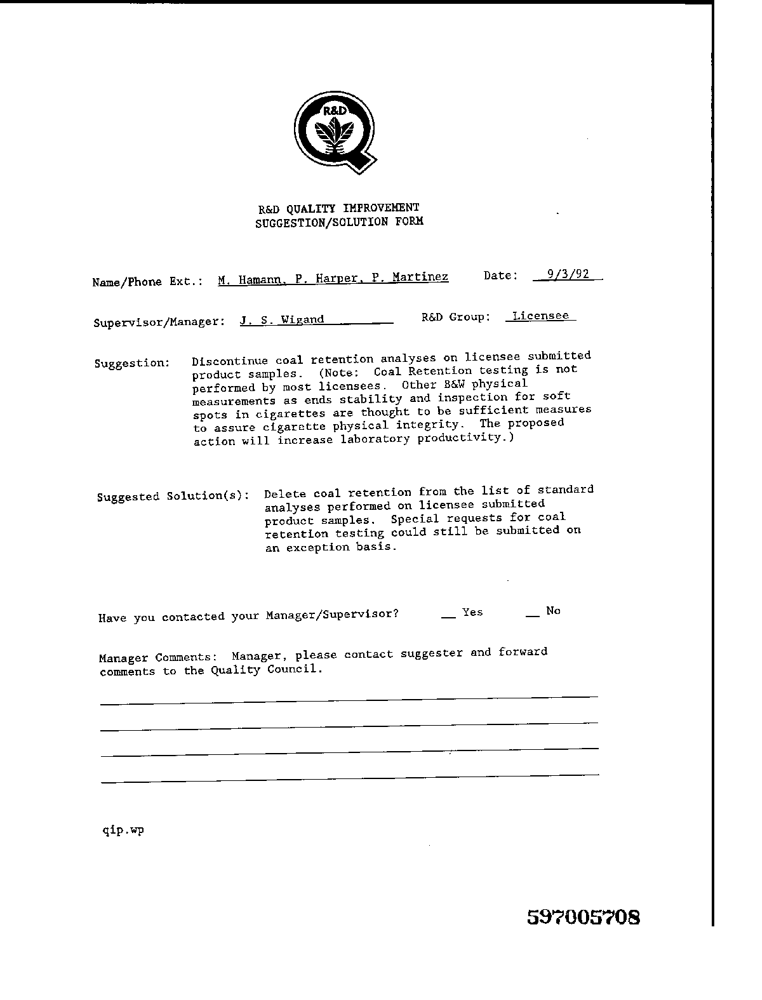

In [4]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/data/training_data/images/0000971160.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [5]:
import json

with open('/content/data/training_data/annotations/0000971160.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [292, 91, 376, 175], 'text': 'R&D', 'label': 'other', 'words': [{'box': [292, 91, 376, 175], 'text': 'R&D'}], 'linking': [], 'id': 0}
{'box': [219, 316, 225, 327], 'text': ':', 'label': 'question', 'words': [{'box': [219, 316, 225, 327], 'text': ':'}], 'linking': [], 'id': 1}
{'box': [95, 355, 169, 370], 'text': 'Suggestion:', 'label': 'question', 'words': [{'box': [95, 355, 169, 370], 'text': 'Suggestion:'}], 'linking': [[2, 16]], 'id': 2}
{'box': [482, 268, 518, 282], 'text': 'Date:', 'label': 'question', 'words': [{'box': [482, 268, 518, 282], 'text': 'Date:'}], 'linking': [[3, 12]], 'id': 3}
{'box': [511, 309, 570, 323], 'text': 'Licensee', 'label': 'answer', 'words': [{'box': [511, 309, 570, 323], 'text': 'Licensee'}], 'linking': [[13, 4]], 'id': 4}
{'box': [211, 651, 217, 662], 'text': '', 'label': 'question', 'words': [{'box': [211, 651, 217, 662], 'text': ''}], 'linking': [], 'id': 5}
{'box': [461, 605, 483, 619], 'text': 'Yes', 'label': 'question', 'words': [{'box': [4

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

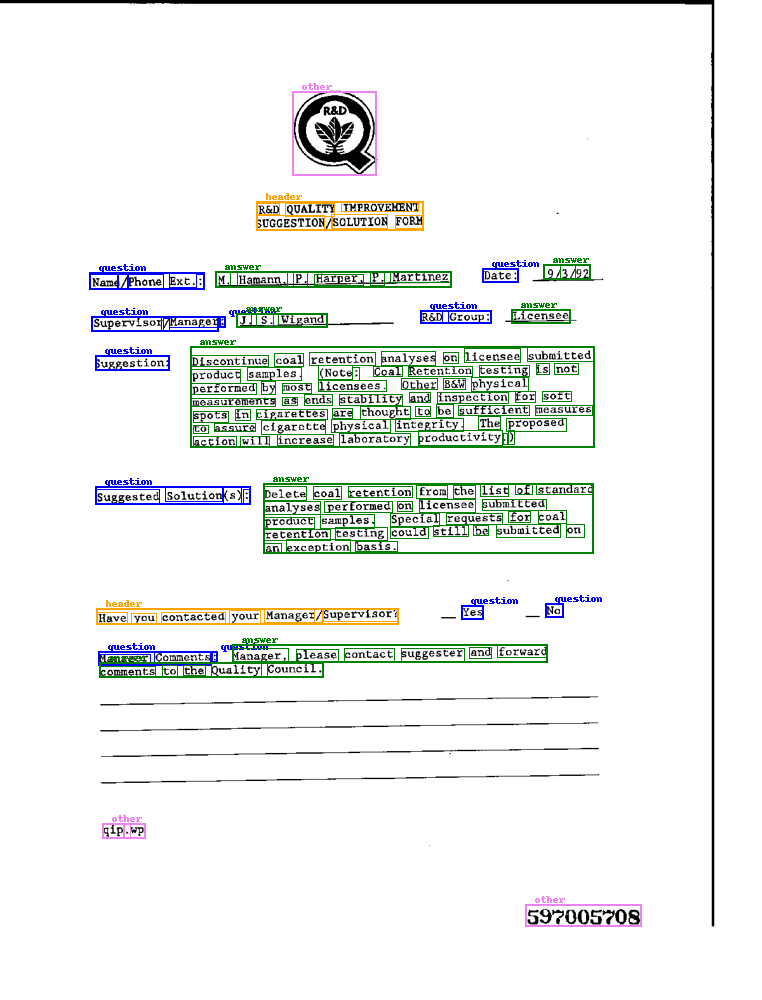

In [6]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [7]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
There was a problem when trying to move your cache:

  File "/usr/local/lib/python3.7/dist-packages/transformers/utils/hub.py", line 1551, in <module>
    move_cache()

  File "/usr/local/lib/python3.7/dist-packages/transformers/utils/hub.py", line 1491, in move_cache
    cached_files = get_all_cached_files(cache_dir=cache_dir)

  File "/usr/local/lib/python3.7/dist-packages/transformers/utils/hub.py", line 1397, in get_all_cached_files
    for file in os.listdir(cache_dir):


Please file an issue at https://github.com/huggingface/transformers/issues/new/choose and copy paste this whole message and we will do our best to help.
Downloading: 100% 170/170 [00:00<00:00, 213kB/s]
Downloading: 100% 606/606 [00:00<00:00, 816kB/s]
vocab_file vocab.txt
Downloading: 1

Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [8]:
! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [9]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [10]:
print(labels)

['B-ANSWER', 'B-HEADER', 'B-QUESTION', 'E-ANSWER', 'E-HEADER', 'E-QUESTION', 'I-ANSWER', 'I-HEADER', 'I-QUESTION', 'O', 'S-ANSWER', 'S-HEADER', 'S-QUESTION']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [11]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

vocab_file vocab.txt
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [12]:
len(train_dataloader)

75

In [13]:
len(eval_dataloader)

26

In [14]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] class a32 solubility water other measured salt base acid reactivity unchanged unchanged unchanged unchanced unchanged unchanged decomposition decomposition decomposition decomposition decomposition decomposition unchanged unchanged unchanged unchanged unchanged unchanged decomposition decomposition decomposition decomposition decomposition decomposition 00837285 air heat light moisture other comments signature date 11 / 1381 g100ml amount other estimated 24 date addendum ii compound physical parameters lrc compound code molecular weight 200. 29 without heating description of reactivity with heating ( 80c ) 1 ) water or brine : 2 ) 5 % hcl 3 ) 5 % naoh : 4 ) alcohols : 5 ) oxygen : 6 ) light : safety comments ( suggested handling procedure ) chemical purity analytical method ( s ) storage recommendations normal storage compound sensitive to x special storage refrigerate in amber bottle at no more than * c ph - the ph of a 50 % concentration of a32 in a 52. 6 % dioxane / water sol

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [15]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Downloading:   0%|          | 0.00/453M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

Now we can start training:

In [16]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 0 steps: 2.6550815105438232


Training:  33%|███▎      | 25/75 [04:17<08:35, 10.32s/it]

Loss after 100 steps: 0.6845124363899231


Training:  67%|██████▋   | 50/75 [08:34<04:17, 10.28s/it]

Loss after 200 steps: 0.5788827538490295


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 300 steps: 0.26822587847709656


Training: 100%|██████████| 75/75 [12:52<00:00, 10.31s/it]


## Evaluation

Now let's evaluate on the test set:

In [17]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 26/26 [01:22<00:00,  3.16s/it]

{'loss': 0.9058671238330694, 'precision': 0.6263387544625149, 'recall': 0.7898949474737369, 'f1': 0.6986725663716814}


## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [18]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,366 kB/s)
debconf: unable to initi

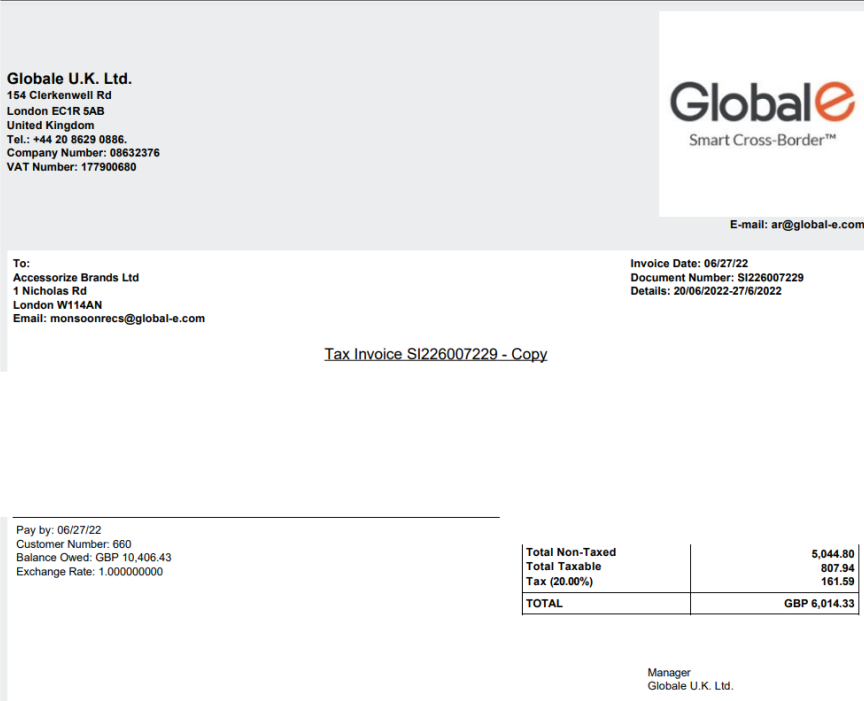

In [80]:
import pytesseract

#image = Image.open('/content/form_example.jpg')
image = Image.open("/content/data/testing_data/images/Screenshot_356.png")
image = image.convert("RGB")
image

Here we run Tesseract (an OCR engine built by Google) on the image:

In [81]:
import numpy as np

width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
            
ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df[:20]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,left_scaled,width_scaled,top_scaled,height_scaled,right_scaled,bottom_scaled
0,5,1,2,1,1,1,7,72,57,12,92,Globale,8,66,103,17,74,120
1,5,1,2,1,1,2,69,72,30,12,96,U.K.,80,35,103,17,115,120
2,5,1,2,1,1,3,104,72,28,12,95,Ltd.,120,32,103,17,153,120
3,5,1,2,2,1,1,7,91,19,8,72,184,8,22,130,11,30,141
4,5,1,2,2,1,2,29,91,64,8,5,Clerkenwell,34,74,130,11,108,141
5,5,1,2,2,1,3,97,91,14,8,77,Rd,112,16,130,11,128,141
6,5,1,2,3,1,1,7,107,41,8,92,London,8,47,153,11,56,164
7,5,1,2,3,1,2,52,107,29,8,83,ECIR,60,34,153,11,94,164
8,5,1,2,3,1,3,83,107,22,8,67,SAB,96,25,153,11,122,164
9,5,1,2,4,1,1,7,121,35,8,96,United,8,41,173,11,49,184


In [82]:
len(ocr_df)

72

Here we create a list of words, actual bounding boxes, and normalized boxes.

In [83]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes

[[8, 102, 74, 119],
 [79, 102, 114, 119],
 [120, 102, 152, 119],
 [8, 129, 30, 141],
 [33, 129, 107, 141],
 [112, 129, 128, 141],
 [8, 152, 55, 164],
 [60, 152, 93, 164],
 [96, 152, 121, 164],
 [8, 172, 48, 184],
 [53, 172, 108, 188],
 [6, 192, 34, 205],
 [38, 192, 60, 203],
 [63, 192, 78, 205],
 [82, 192, 111, 205],
 [114, 192, 146, 205],
 [8, 211, 67, 226],
 [70, 211, 122, 223],
 [127, 211, 185, 223],
 [6, 231, 34, 243],
 [37, 231, 89, 243],
 [93, 231, 157, 243],
 [15, 369, 33, 380],
 [15, 389, 90, 402],
 [93, 389, 137, 402],
 [141, 389, 160, 402],
 [15, 409, 20, 420],
 [25, 407, 79, 420],
 [83, 407, 100, 420],
 [19, 750, 41, 764],
 [45, 750, 59, 764],
 [65, 750, 116, 761],
 [18, 770, 74, 781],
 [78, 770, 126, 781],
 [130, 770, 151, 781],
 [19, 788, 65, 800],
 [69, 788, 103, 801],
 [109, 788, 137, 801],
 [142, 788, 197, 803],
 [19, 808, 76, 824],
 [79, 808, 106, 821],
 [114, 808, 188, 821],
 [775, 116, 989, 174],
 [798, 191, 843, 206],
 [849, 191, 967, 206],
 [844, 313, 887, 326],
 [

This should become the future API of LayoutLMTokenizer (`prepare_for_model()`): 

In [84]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      wordss = []
      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))
          wordss.append(word)
          

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes, wordss

In [85]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes, wordss = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [86]:
print(wordss)

['Globale', 'U.K.', 'Ltd.', '184', 'Clerkenwell', 'Rd', 'London', 'ECIR', 'SAB', 'United', 'Kingdom', 'Tol:', '+44', '20', '8629', '0886.', '‘Company', 'Number:', '08632376', '‘VAT', 'Number:', '177900680', 'To:', '‘Accessorize', 'Brands', 'Ltd', '‘4', 'Nicholas', 'Rd', 'Pay', 'by:', '06/27/22', '‘Customer', 'Number:', '660', 'Balance', 'Owed:', 'GBP', '10,406.43', 'Exchange', 'Rate:', '1.000000', 'Global@', 'Smart', 'Cross-Border™', 'E-mail:', 'ar@global-o.com', 'Invoice', 'Date:', '06/27/22', 'Document', 'Number:', '$1226007229', 'Details:', '20/06/2022-2716/2022', 'Total', 'Non-Taxed', '5,044.80', 'Total', 'Taxable', '807.94|', 'Tax', '(20.00%)', '161.59', '|', 'TOTAL', 'GBP', '6,014.33', 'Manager', 'Globale', 'U.K.', 'Lid.']


In [87]:
tokenizer.decode(input_ids)

'[CLS] globale u. k. ltd. 184 clerkenwell rd london ecir sab united kingdom tol : + 44 20 8629 0886. ‘ company number : 08632376 ‘ vat number : 177900680 to : ‘ accessorize brands ltd ‘ 4 nicholas rd pay by : 06 / 27 / 22 ‘ customer number : 660 balance owed : gbp 10, 406. 43 exchange rate : 1. 000000 global @ smart cross - border™ e - mail : ar @ global - o. com invoice date : 06 / 27 / 22 document number : $ 1226007229 details : 20 / 06 / 2022 - 2716 / 2022 total non - taxed 5, 044. 80 total taxable 807. 94 | tax ( 20. 00 % ) 161. 59 | total gbp 6, 014. 33 manager globale u. k. lid. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Now let's perform a forward pass!

In [88]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

torch.Size([1, 512])

In [89]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

torch.Size([1, 512])

In [90]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

torch.Size([1, 512])

In [91]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

torch.Size([1, 512, 4])

In [92]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs

TokenClassifierOutput([('logits',
                        tensor([[[-0.3674, -0.6590, -1.1564,  ...,  0.1829, -0.2494, -1.1427],
                                 [ 0.8473,  3.5519,  0.5951,  ..., -1.3449, -0.4277, -0.4257],
                                 [-0.6508,  1.1875, -1.4192,  ..., -1.6071, -1.3589, -1.1420],
                                 ...,
                                 [ 1.0362, -0.9091,  0.0266,  ..., -0.6992, -1.7582, -0.5411],
                                 [ 1.3080, -0.8986, -0.0048,  ..., -0.7605, -1.9976, -0.7151],
                                 [ 0.7013, -0.9257, -0.4015,  ..., -1.0136, -1.6380, -0.5099]]],
                               grad_fn=<ViewBackward0>))])

In [93]:
outputs.logits.shape

torch.Size([1, 512, 13])

In [94]:
outputs.logits.argmax(-1)

tensor([[ 9,  1,  7,  7,  4,  7,  4,  4,  4,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9, 12, 12,  9,  9,  9,  9,  9,  9,  9,  9,  9,  2,  2,  5, 12,
         10,  9,  9, 10,  9,  2,  2,  2,  5,  5, 10,  9,  9,  9, 12,  9,  9,  0,
          9,  9,  6,  3,  9,  9,  9,  9,  2,  5,  5,  0,  9,  9,  9,  3,  2,  2,
          5,  5,  9,  2,  5,  5,  0,  9,  3,  9,  3,  3,  3,  2,  5,  5, 10,  9,
          9,  9,  9,  9,  9,  0,  3,  9,  3,  3, 12,  8,  5,  5,  9,  9,  9,  3,
          3,  3,  3,  2,  8,  8,  5,  5,  0,  9,  3,  3,  3,  2,  5,  5,  9,  9,
          9,  9,  9,  9,  9, 12,  5, 10,  9,  9,  9, 10,  9,  9, 10,  9,  9, 10,
          3,  2,  8,  8,  5,  5, 10,  9,  9,  9,  3,  3,  2,  5,  5, 10, 10,  3,
          3,  9,  2,  5,  5,  5,  5,  5,  5, 10,  9,  3,  9,  9,  9,  9,  9,  9,
          9,  9,  3,  3,  9,  9,  9,  9,  4,  9,  4,  9,  4,  4,  9,  9,  9,  9,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,

Of course, LayoutLM outputs labels at the token level, but we are interested in the predicted labels at the word level. So we should actually only incorporate the predicted labels of tokens that are the first token of a given word: 

In [95]:
token_actual_boxes

[[0, 0, 864, 701],
 [7, 72, 64, 84],
 [7, 72, 64, 84],
 [69, 72, 99, 84],
 [69, 72, 99, 84],
 [69, 72, 99, 84],
 [69, 72, 99, 84],
 [104, 72, 132, 84],
 [104, 72, 132, 84],
 [7, 91, 26, 99],
 [29, 91, 93, 99],
 [29, 91, 93, 99],
 [29, 91, 93, 99],
 [97, 91, 111, 99],
 [7, 107, 48, 115],
 [52, 107, 81, 115],
 [52, 107, 81, 115],
 [83, 107, 105, 115],
 [83, 107, 105, 115],
 [7, 121, 42, 129],
 [46, 121, 94, 132],
 [6, 135, 30, 144],
 [6, 135, 30, 144],
 [6, 135, 30, 144],
 [33, 135, 52, 143],
 [33, 135, 52, 143],
 [55, 135, 68, 144],
 [71, 135, 96, 144],
 [71, 135, 96, 144],
 [99, 135, 127, 144],
 [99, 135, 127, 144],
 [99, 135, 127, 144],
 [7, 148, 58, 159],
 [7, 148, 58, 159],
 [61, 148, 106, 157],
 [61, 148, 106, 157],
 [110, 148, 160, 157],
 [110, 148, 160, 157],
 [110, 148, 160, 157],
 [110, 148, 160, 157],
 [110, 148, 160, 157],
 [6, 162, 30, 171],
 [6, 162, 30, 171],
 [6, 162, 30, 171],
 [32, 162, 77, 171],
 [32, 162, 77, 171],
 [81, 162, 136, 171],
 [81, 162, 136, 171],
 [81, 162

In [96]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

# for id, prediction in zip(input_ids.squeeze().tolist(), predictions):
#   if id != 0:
#     print(tokenizer.decode([id]), label_map[prediction])
print(word_level_predictions)

[1, 7, 4, 7, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9, 12, 9, 9, 9, 9, 9, 9, 9, 2, 2, 5, 12, 10, 2, 2, 5, 5, 10, 12, 9, 9, 0, 6, 3, 9, 9, 9, 9, 2, 5, 5, 0, 9, 9, 9, 3, 2, 2, 5, 5, 9, 2, 5, 5, 0, 3, 9, 3, 3, 3, 2, 5, 5, 10, 9, 9, 9, 9, 0, 3, 9, 3, 12, 8, 5, 5, 9, 9, 9, 3, 3, 3, 3, 2, 5, 5, 0, 9, 3, 3, 3, 2, 5, 5, 9, 9, 12, 5, 10, 9, 9, 9, 10, 9, 10, 9, 10, 2, 8, 8, 5, 10, 9, 9, 3, 3, 2, 5, 10, 3, 3, 9, 2, 5, 5, 5, 5, 5, 5, 10, 9, 3, 9, 9, 9, 9, 9, 9, 3, 3, 9, 9, 9, 4, 9, 4, 9, 4]


In [97]:
print(len(word_level_predictions))

153


In [98]:
print(len(final_boxes))

153


Let's visualize the result!

[['B-HEADER', 'Globale'], ['I-HEADER', 'U.K.'], ['E-HEADER', 'Ltd.'], ['I-HEADER', '184'], ['E-HEADER', 'Clerkenwell'], ['E-HEADER', 'Rd'], ['E-HEADER', 'London'], ['O', 'ECIR'], ['O', 'SAB'], ['O', 'United'], ['O', 'Kingdom'], ['O', 'Tol:'], ['O', '+44'], ['O', '20'], ['O', '8629'], ['S-QUESTION', '0886.'], ['O', '‘Company'], ['O', 'Number:'], ['O', '08632376'], ['O', '‘VAT'], ['O', 'Number:'], ['O', '177900680'], ['O', 'To:'], ['B-QUESTION', '‘Accessorize'], ['B-QUESTION', 'Brands'], ['E-QUESTION', 'Ltd'], ['S-QUESTION', '‘4'], ['S-ANSWER', 'Nicholas'], ['B-QUESTION', 'Rd'], ['B-QUESTION', 'Pay'], ['E-QUESTION', 'by:'], ['E-QUESTION', '06/27/22'], ['S-ANSWER', '‘Customer'], ['S-QUESTION', 'Number:'], ['O', '660'], ['O', 'Balance'], ['B-ANSWER', 'Owed:'], ['I-ANSWER', 'GBP'], ['E-ANSWER', '10,406.43'], ['O', 'Exchange'], ['O', 'Rate:'], ['O', '1.000000'], ['O', 'Global@'], ['B-QUESTION', 'Smart'], ['E-QUESTION', 'Cross-Border™'], ['E-QUESTION', 'E-mail:'], ['B-ANSWER', 'ar@global-o.co

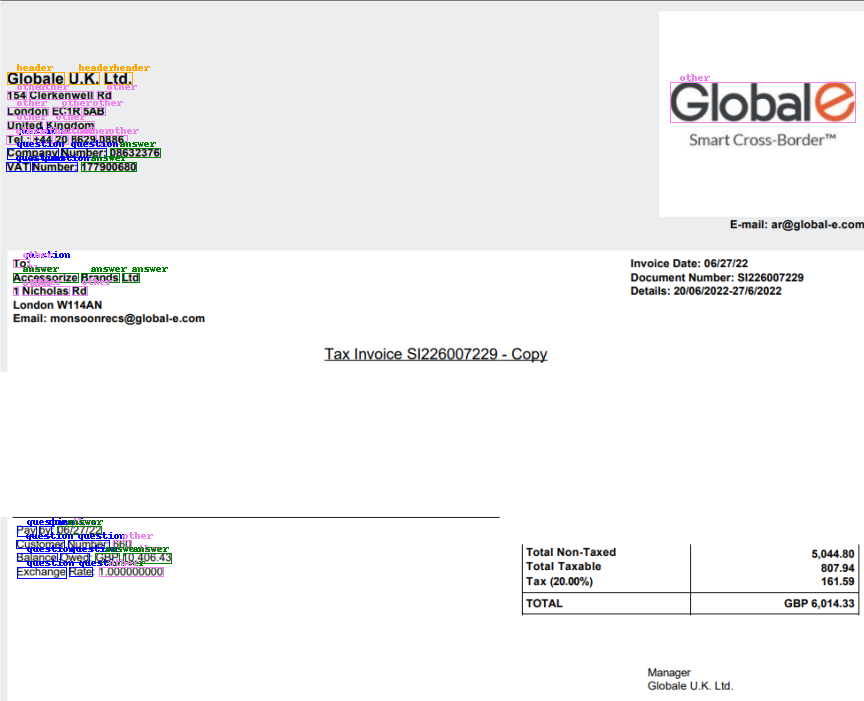

In [99]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
SimpleData = []
for prediction, box, word in zip(word_level_predictions, final_boxes, wordss):
    SimpleData.append([label_map[prediction], word])
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
print(SimpleData)
image

Compare this to the ground truth:

In [37]:
import json

with open('/content/data/testing_data/annotations/83443897.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [91, 223, 127, 238], 'text': 'DATE:', 'label': 'question', 'words': [{'box': [91, 223, 127, 238], 'text': 'DATE:'}], 'linking': [[0, 15]], 'id': 0}
{'box': [89, 313, 153, 330], 'text': 'COMPANY:', 'label': 'question', 'words': [{'box': [89, 313, 153, 330], 'text': 'COMPANY:'}], 'linking': [[1, 18]], 'id': 1}
{'box': [91, 366, 134, 384], 'text': 'PHONE:', 'label': 'question', 'words': [{'box': [91, 366, 134, 384], 'text': 'PHONE:'}], 'linking': [[2, 20]], 'id': 2}
{'box': [88, 402, 129, 417], 'text': 'FROM:', 'label': 'question', 'words': [{'box': [88, 402, 129, 417], 'text': 'FROM:'}], 'linking': [[3, 21]], 'id': 3}
{'box': [91, 432, 136, 446], 'text': 'PHONE:', 'label': 'question', 'words': [{'box': [91, 432, 136, 446], 'text': 'PHONE:'}], 'linking': [[4, 22]], 'id': 4}
{'box': [87, 483, 150, 497], 'text': 'MESSAGE:', 'label': 'question', 'words': [{'box': [87, 483, 150, 497], 'text': 'MESSAGE:'}], 'linking': [[5, 29], [5, 28]], 'id': 5}
{'box': [486, 461, 513, 475], 'text': '

Note that we only print the labels for the general bounding boxes, for readability. Each general bounding box consists of one or more bounding boxes, which comprise the individual words:

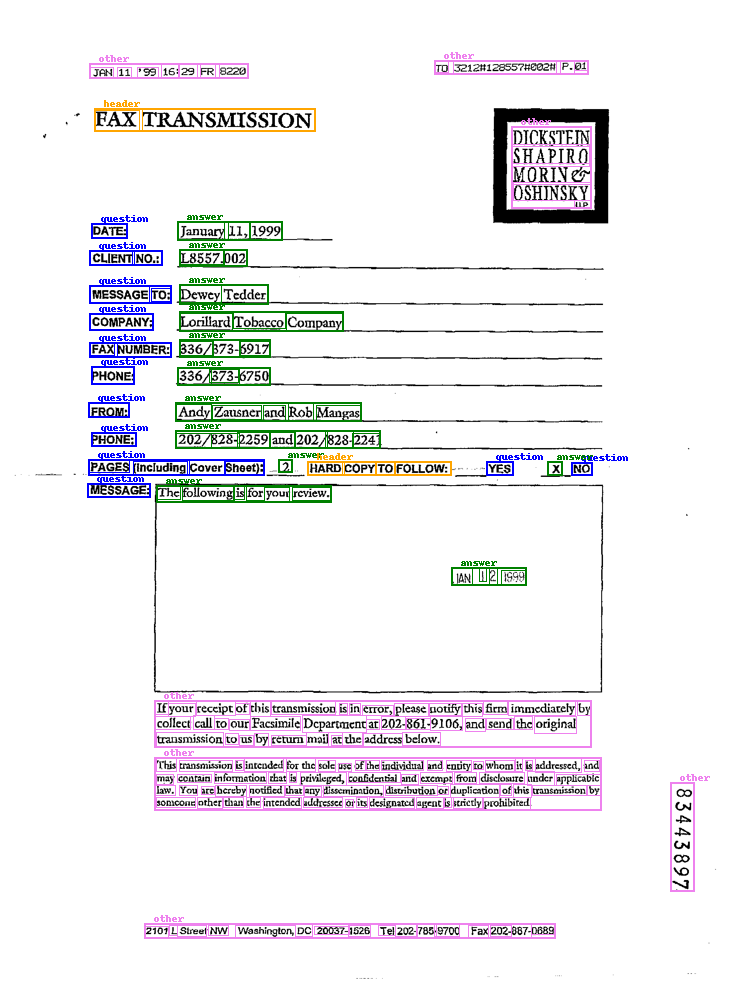

In [38]:
image = Image.open("/content/data/testing_data/images/83443897.png")
image = image.convert('RGB')

draw = ImageDraw.Draw(image)

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Legacy

The code below was used during the development of this notebook, but is not used anymore.

In [39]:
# from transformers import AdamW, get_linear_schedule_with_warmup

# # Prepare optimizer and schedule (linear warmup and decay)
# no_decay = ["bias", "LayerNorm.weight"]
# optimizer_grouped_parameters = [
#     {
#         "params": [
#             p
#             for n, p in model.named_parameters()
#             if not any(nd in n for nd in no_decay)
#         ],
#         "weight_decay": 0.0,
#     },
#     {
#         "params": [
#             p
#             for n, p in model.named_parameters()
#             if any(nd in n for nd in no_decay)
#         ],
#         "weight_decay": 0.0,
#     },
# ]

# optimizer = AdamW(
#     optimizer_grouped_parameters, lr=5e-5, eps=1e-8
# )

# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=0, num_training_steps=-1
# )